# Лабораторная работа №4

In [508]:
import matplotlib.pyplot as plt
import numpy as np

from numpy.fft import fft, ifft, fftfreq
from scipy.special import binom
from typing import Union

In [509]:
def cyclic_freq(T: float):
    return 2 * np.pi / T

In [510]:
def period(f: float):
    return 1 / f

In [511]:
def apply_fft(func, dt: float, y: np.ndarray):

    xfft = fftfreq(y.size) / dt
    yfft = func(y)

    return xfft, yfft

In [512]:
def cos_func(x: float, A: float, w: float):
    return A * np.cos(w * x)

In [513]:
def func_x(func, A: float, T: Union[float, list, tuple], interval: tuple, sample_rate: int = 1000):

    x, step = np.linspace(interval[0], 
                          interval[1], 
                          num = sample_rate, 
                          endpoint = False, 
                          retstep = True)

    if isinstance(T, float):
        y = np.apply_along_axis(lambda z: func(z, A, cyclic_freq(T)), 0, x)
    else:
        y = np.sum([
            np.apply_along_axis(lambda z: func(z, A, cyclic_freq(T[t])), 0, x)
            for t in range(len(T))],
            axis = 0)
    
    return x, y, step

In [514]:
def plot_signal(**kwards):
    
    # Точки временного пространства
    x  = kwards.get('x')
    y0 = kwards.get('y0')
    y1 = kwards.get('y1')
    
    # Точки частотного пространства
    xf  = kwards.get('xf')
    yf0 = kwards.get('yf0')
    yf1 = kwards.get('yf1')

    # Ограничение оси абсцисс
    t = kwards.get('t')
    f = kwards.get('f')

    # Легенды графиков
    legendy0  = kwards.get('legend_y0')
    legendy1  = kwards.get('legend_y1')
    legendyf0 = kwards.get('legend_yf0')
    legendyf1 = kwards.get('legend_yf1')

    # Название графика
    title = kwards.get('title')

    fig = plt.figure()

    if y0 is not None:    
        ax = fig.add_subplot(211)

        ids = range(len(xf))
 
        if t is not None:   
            ids = np.logical_and(x >= t[0], x <= t[1])

        ax.plot(x[ids], y0[ids], 'b', label = legendy0)

        if y1 is not None:
            ax.plot(x[ids], y1[ids], '--', color = 'r', label = legendy1) 

        ax.set_ylabel('Амплитуда')
        ax.set_xlabel('Время, с')

        if any([legendy0, legendy1]):
            ax.legend(loc = 'upper right')

        ax.grid()

    if yf0 is not None:
        ax = fig.add_subplot(212)

        ids = range(len(xf))

        if f is not None: 
            ids = np.logical_and(xf >= f[0], xf <= f[1])

        ax.plot(xf[ids], 2 * np.abs(yf0[ids]) / len(yf0), color = 'b', label = legendyf0)

        if yf1 is not None:
            ax.plot(xf[ids], np.abs(yf1[ids]), '--', color = 'r', label = legendyf1, linewidth = 1)

        ax.set_ylabel('Амплитуда')
        ax.set_xlabel('Частота, Гц')

        if any([legendyf0, legendyf1]):
            ax.legend(loc = 'upper right')

        ax.grid()

    if title is not None:
        plt.suptitle(title)

    fig.set_figwidth(8)
    fig.set_figheight(2 * len(fig.axes))

    fig.tight_layout()
    plt.show()

## Задание 1

In [515]:
SAMPLE_RATE = 5000
interval  = (0, 1)
A  = 1
f1 = 50
f2 = 150
f3 = 450

In [516]:
x, y0, step = func_x(cos_func, A, [period(f1), period(f2), period(f3)] , interval, SAMPLE_RATE)
xfft, yfft0 = apply_fft(fft, step, y0)

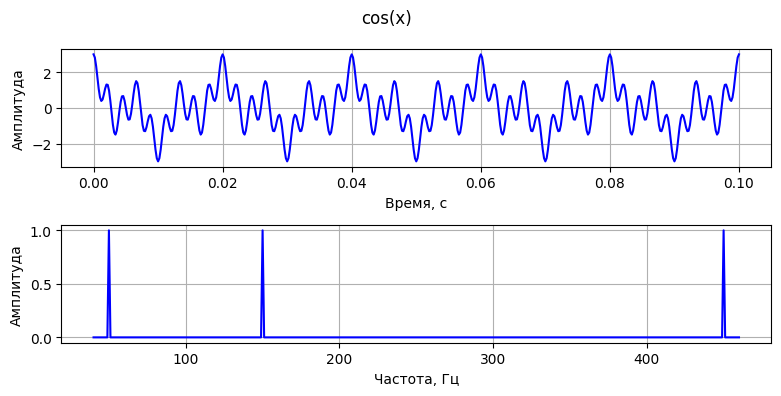

In [517]:
plot_signal(x = x, y0 = y0, xf = xfft, yf0 = yfft0, t = (0, 0.1), f = (40, 460), 
            title = 'cos(x)')

## Задание 2

In [518]:
class Butterworth_filter:

    def __init__(self, signal: np.ndarray, step: float):
        self.xfft, self.yfft = apply_fft(fft, step, signal)

    def update_signal(self, signal : np.ndarray, step: float):
        self.xfft, self.yfft = apply_fft(fft, step, signal)

    def H_w(self, w: np.ndarray, wc: Union[float, list], mode: str = 'LPF', order: int = 2):

        arg = [1j * np.pi * (2 * k + order - 1) / (2 * order) for k in range(order)]
        sk = np.mean(wc) * np.exp(arg)
        s = 1j * w[np.newaxis].T
        
        if mode == 'LPF':
            numer = wc ** order
            
        elif mode == 'HPF':
            numer = w ** order
            
        elif mode == 'BPF':
            return self.H_w(self.xfft, wc[0], 'LPF', order) * \
                   self.H_w(self.xfft, wc[1], 'HPF', order)

        elif mode == 'BF':
            B = wc[1] - wc[0]
            w0 = wc[0] * wc[1]
            s = (B * s) / (s ** 2 + w0)
            numer = np.sum(wc) ** order / order
            
        return numer / (order * np.prod(s - sk, axis = 1))       
        
    def LPF(self, wc: float, order: int = 2):        
        return ifft(np.abs(self.H_w(self.xfft, wc, 'LPF', order) * self.yfft))
    
    def HPF(self, wc: float, order: int = 2):      
        return ifft(np.abs(self.H_w(self.xfft, wc, 'HPF', order) * self.yfft))
    
    def BPF(self, wc1: float, wc2: float, order: int = 2):
        Hw = self.H_w(self.xfft, wc1, 'LPF', order) * self.H_w(self.xfft, wc2, 'HPF', order)
        return ifft(np.abs(Hw * self.yfft))
    
    def BF(self, wc1: float, wc2: float, order: int = 2):
        #Hw = self.H_w(self.xfft, wc1, 'LPF', order) + self.H_w(self.xfft, wc2, 'HPF', order)
        #return ifft(np.abs(Hw * self.yfft))
        return ifft(np.abs(self.H_w(self.xfft, [wc1 , wc2], 'BF', order) * self.yfft))

In [519]:
butterworth = Butterworth_filter(y0, step)

In [520]:
order = 2
wc = 70

y1 = butterworth.LPF(wc = wc, order = order) 
yfft1 = apply_fft(fft, step, y1)[1]
Hw = butterworth.H_w(butterworth.xfft, wc, 'LPF', order = order)

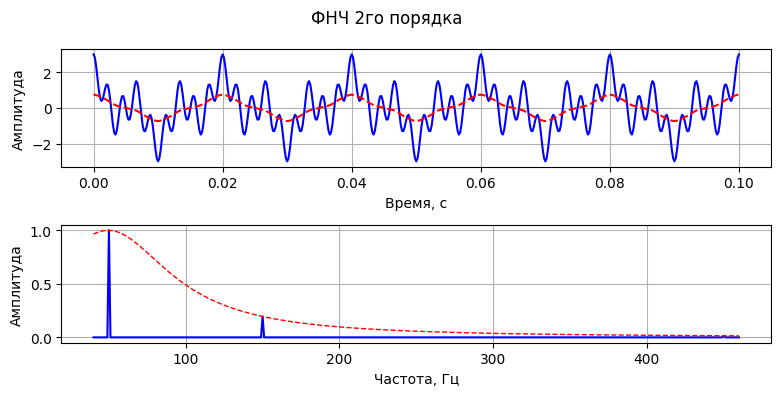

In [521]:
plot_signal(x = x, y0 = y0, y1 = y1, xf = xfft, yf0 = yfft1, yf1 = Hw, t = (0, 0.1), f = (40, 460), 
            title = f'ФНЧ {order}го порядка')

## Задание 3

In [522]:
order = 2
wc = 300

y1 = butterworth.HPF(wc = wc, order = order) 
yfft1 = apply_fft(fft, step, y1)[1]
Hw = butterworth.H_w(butterworth.xfft, wc, 'HPF', order = order)

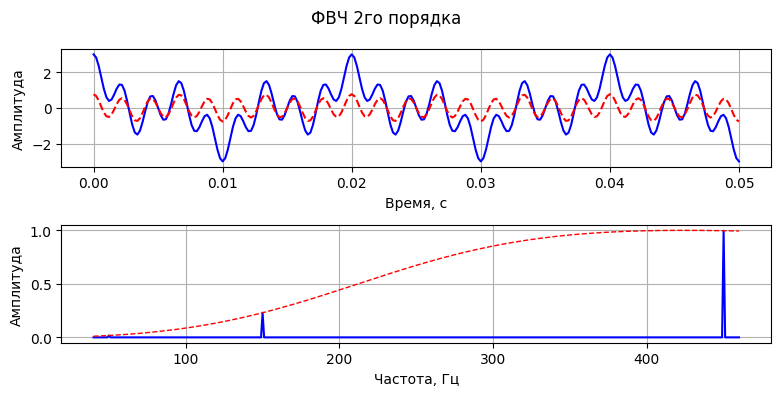

In [523]:
plot_signal(x = x, y0 = y0, y1 = y1, xf = xfft, yf0 = yfft1, yf1 = Hw, t = (0, 0.05), f = (40, 460), 
            title = f'ФВЧ {order}го порядка')

## Задание 4

In [524]:
order = 2
wc1 = 140
wc2 = 160

y1 = butterworth.BPF(wc1 = wc1, wc2 = wc2, order = order) 
yfft1 = apply_fft(fft, step, y1)[1]
Hw = butterworth.H_w(butterworth.xfft, [wc1, wc2], 'BPF', order = order)

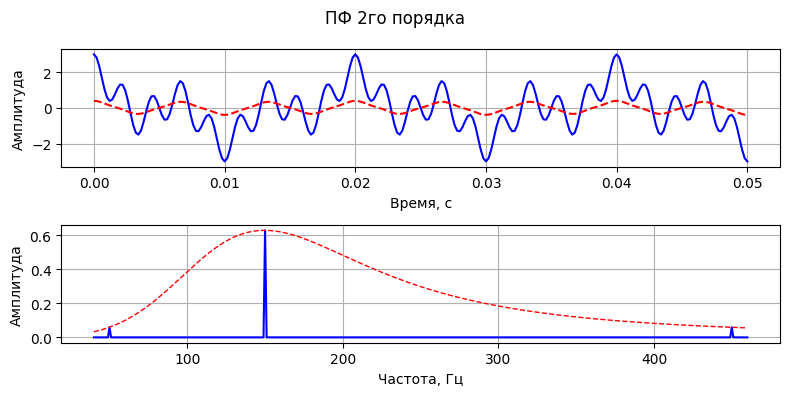

In [525]:
plot_signal(x = x, y0 = y0, y1 = y1, xf = xfft, yf0 = yfft1, yf1 = Hw, t = (0, 0.05), f = (40, 460), 
            title = f'ПФ {order}го порядка')

In [526]:
order = 2
wc1 = 140
wc2 = 160

y1 = butterworth.BF(wc1 = wc1, wc2 = wc2, order = order) 
yfft1 = apply_fft(fft, step, y1)[1]
Hw = butterworth.H_w(butterworth.xfft, [wc1, wc2], 'BF', order = order)

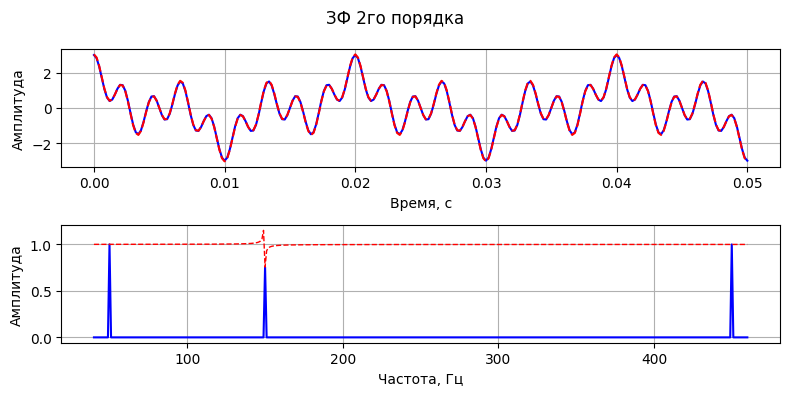

In [527]:
plot_signal(x = x, y0 = y0, y1 = y1, xf = xfft, yf0 = yfft1, yf1 = Hw, t = (0, 0.05), f = (40, 460), 
            title = f'ЗФ {order}го порядка')

## Задание 5

In [528]:
order = 4
wc = 70

y1 = butterworth.LPF(wc = wc, order = order) 
yfft1 = apply_fft(fft, step, y1)[1]
Hw = butterworth.H_w(butterworth.xfft, wc, 'LPF', order = order)

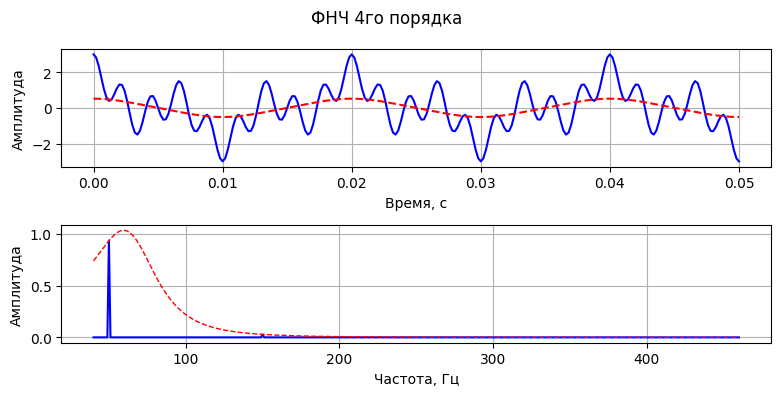

In [529]:
plot_signal(x = x, y0 = y0, y1 = y1, xf = xfft, yf0 = yfft1, yf1 = Hw, t = (0, 0.05), f = (40, 460), 
            title = f'ФНЧ {order}го порядка')

## Задание 6

In [530]:
y1 = y0 + np.random.normal(0, 1, len(y0))
butterworth.update_signal(y1, step)

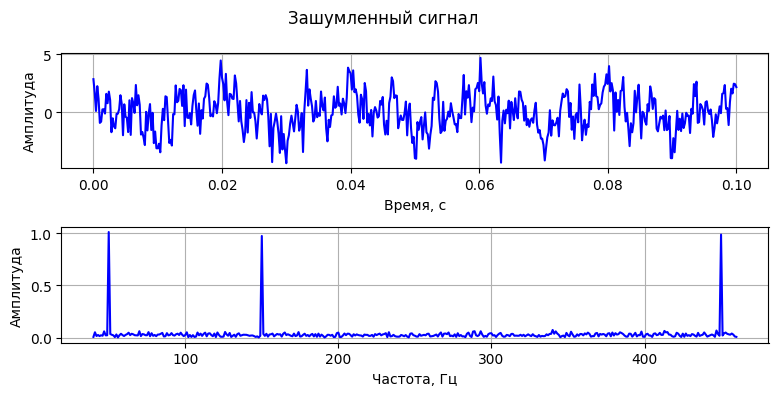

In [531]:
yfft1 = apply_fft(fft, step, y1)[1]

plot_signal(x = x, y0 = y1, xf = xfft, yf0 = yfft1, t = (0, 0.1), f = (40, 460), 
            title = 'Зашумленный сигнал')

In [532]:
order = 2
wc = 70

y2 = butterworth.LPF(wc = wc, order = order) 
yfft1 = apply_fft(fft, step, y2)[1]
Hw = butterworth.H_w(butterworth.xfft, wc, 'LPF', order = order)

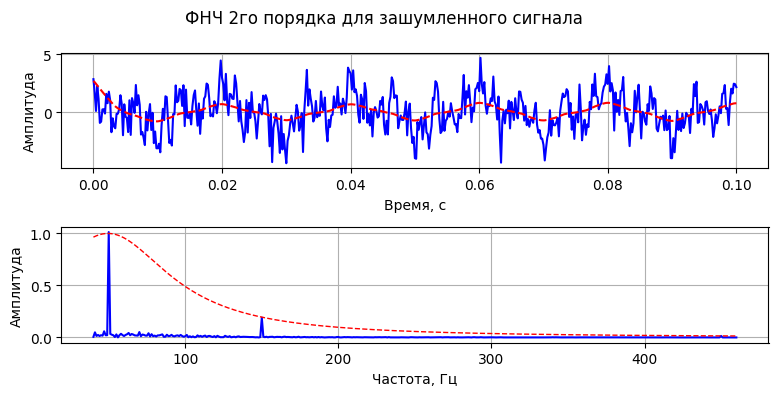

In [533]:
plot_signal(x = x, y0 = y1, y1 = y2, xf = xfft, yf0 = yfft1, yf1 = Hw, t = (0, 0.1), f = (40, 460), 
            title = f'ФНЧ {order}го порядка для зашумленного сигнала')

## Задание 7

In [534]:
class Chebyshev_filter:

    def __init__(self, signal: np.ndarray, step: float):
        self.xfft, self.yfft = apply_fft(fft, step, signal)

    def update_signal(self, signal : np.ndarray, step: float):
        self.xfft, self.yfft = apply_fft(fft, step, signal)

    def H_w(self, w: float, wc: float, eps: float = 0.1, order: int = 2):
        
        x = w / wc

        C = np.array([binom(order, 2 * k) for k in range(order // 2)]).T
        arg1 = np.array([(x ** 2 - 1) ** k for k in range(order // 2)])
        arg2 = np.array([x ** (order - 2 * k) for k in range(order // 2)])

        T = np.sum(C * arg1 * arg2, axis = 0)

        return 1 / np.sqrt(1 + eps ** 2 * T ** 2) 

    def LPF(self, wc: np.ndarray, eps: float, order: int = 2):

        return ifft(np.abs(self.H_w(self.xfft, wc, eps, order) * self.yfft))

In [535]:
chebyshev = Chebyshev_filter(y0, step)

In [536]:
order = 2
wc = 70
eps = 0.1

y1 = chebyshev.LPF(wc = wc, eps = eps, order = order) 
yfft1 = apply_fft(fft, step, y1)[1]
Hw = chebyshev.H_w(chebyshev.xfft, wc, eps = eps, order = order)

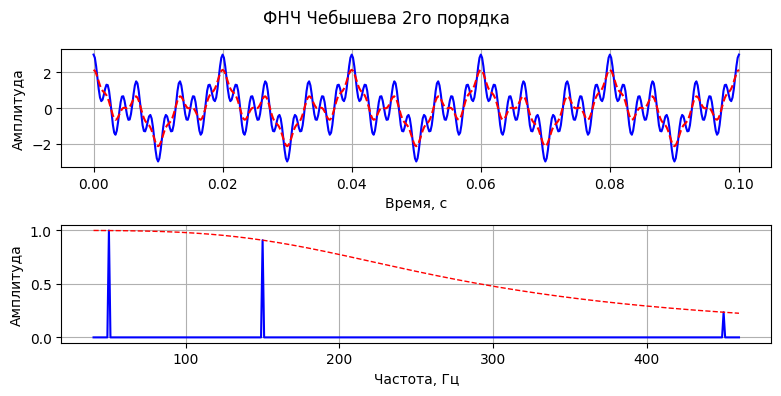

In [537]:
plot_signal(x = x, y0 = y0, y1 = y1, xf = xfft, yf0 = yfft1, yf1 = Hw, t = (0, 0.1), f = (40, 460), 
            title = f'ФНЧ Чебышева {order}го порядка')